In [2]:
#%% Set data path
data_path = r'./database'

In [4]:
#importing all needed packages
import os
import glob
import nibabel as nib
import numpy as np
import monai
import torch
import torch.optim as optim
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from monai.transforms import Compose, ScaleIntensityd, EnsureChannelFirstd, RandZoomd, RandFlipd, RandRotated, Resized, RandAdjustContrastd, RandGaussianSmoothd, RandGaussianNoised, Rand2DElasticd, RandShiftIntensityd
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.utils import one_hot
from monai.networks.nets import UNet
from sklearn.model_selection import KFold
from tqdm import tqdm
import wandb
import cv2
#wandb.login()

2025-04-03 11:38:54.420299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 11:38:54.420331: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-03 11:38:54.420373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 11:38:54.429212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 11:38:55.677209: W tensorflow/compiler/

In [5]:
#%% Adapted Script for Heart MRI Segmentation using a 2D UNet with Cross-Validation and Learning Rate Scheduling

#%% Utility function for loading NIfTI images
def load_nii(img_path):
    nimg = nib.load(img_path)
    return nimg.get_fdata(), nimg.affine, nimg.header

#%% Build dataset dictionary
def build_dict(data_path):
    image_dir = os.path.join(data_path, "training", "image")
    mask_dir = os.path.join(data_path, "training", "segmentation")
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*_gt.nii.gz")))
    mask_dict = {os.path.basename(m).replace("_gt", ""): m for m in mask_paths}
    dataset_dicts = []
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        patient_number = filename.split('_')[0]
        mask_path = mask_dict.get(filename, None)
        if mask_path and os.path.exists(mask_path):
            dataset_dicts.append({"patient": patient_number, "img": img_path, "mask": mask_path})
    return dataset_dicts

#%% Custom Transform to Load All Slices of Data
class LoadHeartData(monai.transforms.Transform):
    def __call__(self, sample):
        img_vol, _, _ = load_nii(sample['img'])
        mask_vol, _, _ = load_nii(sample['mask'])
        images = np.moveaxis(img_vol, -1, 0)
        masks = np.moveaxis(mask_vol, -1, 0)
        slice_list = []
        for i in range(images.shape[0]):
            slice_list.append({
                'img': images[i].astype(np.float32),
                'mask': masks[i].astype(np.uint8),
                'img_meta_dict': {'affine': np.eye(2)},
                'mask_meta_dict': {'affine': np.eye(2)}
            })
        return slice_list

#%% Set data path
main_path = r'./database'
#main_path = r"/content/drive/MyDrive/ACDC/database"

#%% Build dataset dictionary (training + validation combined for CV)
dataset_dicts = build_dict(main_path)

#%% Define transforms
transforms = Compose([
    LoadHeartData(),
    EnsureChannelFirstd(keys=['img', 'mask'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['img'], minv=0, maxv=1),
    Resized(keys=['img', 'mask'], spatial_size=(256, 256), mode=['bilinear', 'nearest']),
    RandZoomd(keys=['img', 'mask'], min_zoom=0.9, max_zoom=1.1, mode=['bilinear', 'nearest'], prob=0.5),
    RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=1),
    RandRotated(keys=['img', 'mask'], range_x=0.1, range_y=0.1, mode=['bilinear', 'nearest'], prob=0.5),
    Rand2DElasticd(keys=['img', 'mask'], spacing=(5, 5), magnitude_range=(0, 0.1), prob=0.5, mode=['bilinear', 'nearest']),
    RandAdjustContrastd(keys=['img'], gamma=(0.8, 1.2), prob=0.3),
    RandGaussianSmoothd(keys=['img'], sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5), prob=0.3),
    RandGaussianNoised(keys=['img'], prob=0.3, mean=0.0, std=0.05),
    RandShiftIntensityd(keys=['img'], prob=0.5, offsets=(10,20))
])

In [6]:
#%% Flatten dataset to handle all slices
def flatten_dataset(dataset_list, transform):
    flat_list = []
    for data in dataset_list:
        flat_list.extend(transform(data))
    return flat_list

full_dataset = flatten_dataset(dataset_dicts * 3, transforms)
full_dataset = np.array(full_dataset)  # Convert to numpy for indexing in cross-validation

#%% Cross-Validation Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 200
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_results = []
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [7]:
model_dir = "." 

#%% Utility function for loading NIfTI images
def load_nii(img_path):
    nimg = nib.load(img_path)
    return nimg.get_fdata(), nimg.affine, nimg.header

#%% Build a dictionary for the test dataset
def build_test_dict(data_path):
    image_dir = os.path.join(data_path, "testing", "image")
    mask_dir = os.path.join(data_path, "testing", "segmentation")

    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*_gt.nii.gz")))

    mask_dict = {os.path.basename(m).replace("_gt", ""): m for m in mask_paths}
    dataset_dicts = []
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        patient_number = filename.split('_')[0]
        mask_path = mask_dict.get(filename, None)
        if mask_path and os.path.exists(mask_path):
            dataset_dicts.append({"patient": patient_number, "img": img_path, "mask": mask_path, "img_meta_dict": {"filename": filename, "patient_id": patient_number}})
    return dataset_dicts

#%% Custom Transform to Load All Slices of Data (same as training)
class LoadHeartData(monai.transforms.Transform):
    def __call__(self, sample):
        img_vol, _, _ = load_nii(sample['img'])
        mask_vol, _, _ = load_nii(sample['mask'])
        images = np.moveaxis(img_vol, -1, 0)
        masks = np.moveaxis(mask_vol, -1, 0)
        slice_list = []
        for i in range(images.shape[0]):
            slice_list.append({
                'img': images[i].astype(np.float32),
                'mask': masks[i].astype(np.uint8),
                'img_meta_dict': {'affine': np.eye(2)},
                'mask_meta_dict': {'affine': np.eye(2)}
            })
        return slice_list

#%% Define test transforms (using same ones as validation)
test_transforms = Compose([
    LoadHeartData(),
    EnsureChannelFirstd(keys=['img', 'mask'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['img']),
    Resized(keys=['img', 'mask'], spatial_size=(256, 256), mode=['bilinear', 'nearest']),
])

#%% Build and flatten the test dataset
test_dicts = build_test_dict(r'./database')
def flatten_dataset(dataset_list, transform):
    flat_list = []
    for data in dataset_list:
        flat_list.extend(transform(data))
    return flat_list

test_flat = flatten_dataset(test_dicts, test_transforms)
test_flat = np.array(test_flat)

#%% Create test DataLoader
test_dataset = monai.data.Dataset(data=test_flat)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#%% Function to load ensemble models
def load_ensemble_models(model_paths, device):
    models = []
    for path in model_paths:
        model = UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=4,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        ).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        models.append(model)
    return models

#%% Define the EnsembleModel globally to avoid pickle issues
class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, x):
        # Collect and average the predictions (soft voting)
        outputs_list = [torch.softmax(model(x), dim=1) for model in self.models]
        avg_outputs = torch.mean(torch.stack(outputs_list), dim=0)
        return avg_outputs

#%% Compute Dice Score After Soft Voting (Averaging Outputs)
def compute_ensemble_dice(model_paths, device, test_dataloader):
    # Load ensemble models
    ensemble_models = load_ensemble_models(model_paths, device)
    ensemble_model = EnsembleModel(ensemble_models)

    # Initialize Dice metric
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    dice_metric.reset()

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            images = batch["img"].to(device)

            # Perform inference with the ensemble model
            avg_outputs = ensemble_model(images)

            # Get the predicted class by selecting the class with the highest probability
            preds = torch.argmax(avg_outputs, dim=1, keepdim=True)
            preds_onehot = one_hot(preds, num_classes=4)
            masks = batch["mask"].to(device).unsqueeze(1)
            masks_onehot = one_hot(masks, num_classes=4)

            # Calculate the Dice score for the current batch
            dice_metric(y_pred=preds_onehot, y=masks_onehot)

    # Aggregate the Dice score for the whole dataset
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()
    return dice_score

#%% Save the ensemble model
def save_ensemble_model(model_paths, device, save_path):
    ensemble_models = load_ensemble_models(model_paths, device)
    ensemble_model = EnsembleModel(ensemble_models)

    # Save the entire model instead of just state_dict
    torch.save(ensemble_model, save_path)
    print(f"Averaged Ensemble Model saved at: {save_path}")
    return ensemble_model

#%% Main Execution
model_paths = [os.path.join(model_dir, f"bestHeartUNet_Fold{i+1}.pt") for i in range(5)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute the Dice score for the ensemble model
dice_score = compute_ensemble_dice(model_paths, device, test_dataloader)

# Save the entire ensemble model
ensemble_model_path = os.path.join(model_dir, "ensembleHeartUNet.pt")
save_ensemble_model(model_paths, device, ensemble_model_path)

print(f"Ensemble Dice Score on Test Dataset: {dice_score}")


100%|██████████| 1076/1076 [02:21<00:00,  7.58it/s]


Averaged Ensemble Model saved at: ./ensembleHeartUNet.pt
Ensemble Dice Score on Test Dataset: 0.8941125869750977


In [8]:
#FOR UNCERTAINTY #https://medium.com/biased-algorithms/uncertainty-estimation-in-machine-learning-with-monte-carlo-dropout-72377f5ee276

ensemble_model_path = "ensembleHeartUNet.pt"
#%% Main Execution
model_paths = [os.path.join(model_dir, f"bestHeartUNet_Fold{i+1}.pt") for i in range(5)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EnsembleModel with MC Dropout for uncertainty calculation
class EnsembleModelWithUncertainty(torch.nn.Module):
    def __init__(self, models, num_samples_mc=10):
        super(EnsembleModelWithUncertainty, self).__init__()
        self.models = torch.nn.ModuleList(models)
        self.num_samples_mc = num_samples_mc  # Number of Monte Carlo samples

    def forward(self, x):
        outputs_list = []
        for model in self.models:
            model.train()  # Dropout is actief
            model_outputs = []
            for _ in range(self.num_samples_mc):
                model_outputs.append(torch.softmax(model(x), dim=1))  # Voorspellingen met actieve dropout
            outputs_list.append(torch.stack(model_outputs, dim=0))  # [num_samples_mc, B, C, H, W]

        # Combineer alle voorspellingen van het ensemble
        all_outputs = torch.cat(outputs_list, dim=0)  # [num_samples_mc * len(models), B, C, H, W]

        # Bereken het gemiddelde en de standaarddeviatie
        mean_output = torch.mean(all_outputs, dim=0)  # Gemiddelde voorspelling (mean_pred)
        std_output = torch.std(all_outputs, dim=0)    # Standaarddeviatie (uncertainty)

        return mean_output, std_output  # Retourneer zowel het gemiddelde als de standaarddeviatie

# In your evaluation phase:
def compute_ensemble_dice_and_uncertainty(model_paths, device, test_dataloader, num_samples_mc=10):
    # Load ensemble models
    ensemble_models = load_ensemble_models(model_paths, device)
    ensemble_model = EnsembleModelWithUncertainty(ensemble_models, num_samples_mc)
    
    # Initialize Dice metric and empty list for uncertainty maps
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    dice_metric.reset()
    uncertainty_maps = []
    total_uncertainty = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            images = batch["img"].to(device)
            # Perform inference with the ensemble model and get predictions
            mean_pred, std_pred = ensemble_model(images)
            # Calculate Dice score for the current batch
            preds = torch.argmax(mean_pred, dim=1, keepdim=True)  # Select the class with the highest probability
            preds_onehot = one_hot(preds, num_classes=4)
            masks = batch["mask"].to(device).unsqueeze(1)
            masks_onehot = one_hot(masks, num_classes=4)
            dice_metric(y_pred=preds_onehot, y=masks_onehot)

            # Calculate and store uncertainty (e.g., standard deviation)
            batch_uncertainty = std_pred.mean().item()  # Gemiddelde onzekerheid per batch
            total_uncertainty += batch_uncertainty
            num_batches += 1
            uncertainty_maps.append(std_pred.cpu().numpy())  # Add uncertainty map
            
    # Aggregate the Dice score for the whole dataset
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()
    
    # Compute overall uncertainty score
    avg_uncertainty = total_uncertainty / num_batches if num_batches > 0 else 0.0
    # Return the Dice score, the list of uncertainty maps, and overall uncertainty score
    return dice_score, uncertainty_maps, avg_uncertainty

# In your main code:
dice_score, uncertainty_maps, avg_uncertainty = compute_ensemble_dice_and_uncertainty(model_paths, device, test_dataloader)

# Now you can use the uncertainty maps (std_pred) for visualization or further analysis
print(f"Ensemble Dice Score on Test Dataset: {dice_score}")
print(f"Overall Uncertainty Score: {avg_uncertainty}")


100%|██████████| 1076/1076 [24:35<00:00,  1.37s/it] 

Ensemble Dice Score on Test Dataset: 0.8941083550453186
Overall Uncertainty Score: 0.002602114389549918


In [9]:
#LOAD ONLY PATIENT in map
model_dir = "." 
#%% Main Execution
model_paths = [os.path.join(model_dir, f"bestHeartUNet_Fold{i+1}.pt") for i in range(5)]
#%% Utility function for loading NIfTI images
def load_nii(img_path):
    nimg = nib.load(img_path)
    return nimg.get_fdata(), nimg.affine, nimg.header

#%% Build a dictionary for the test dataset
def build_test_dict(data_path):
    image_dir = os.path.join(data_path, "testing", "patient1")
    mask_dir = os.path.join(data_path, "testing", "patient1seg")

    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*_gt.nii.gz")))

    mask_dict = {os.path.basename(m).replace("_gt", ""): m for m in mask_paths}
    dataset_dicts = []
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        patient_number = filename.split('_')[0]
        mask_path = mask_dict.get(filename, None)
        if mask_path and os.path.exists(mask_path):
            dataset_dicts.append({"patient": patient_number, "img": img_path, "mask": mask_path, "img_meta_dict": {"filename": filename, "patient_id": patient_number}})
    return dataset_dicts

#%% Custom Transform to Load All Slices of Data (same as training)
class LoadHeartData(monai.transforms.Transform):
    def __call__(self, sample):
        img_vol, _, _ = load_nii(sample['img'])
        mask_vol, _, _ = load_nii(sample['mask'])
        images = np.moveaxis(img_vol, -1, 0)
        masks = np.moveaxis(mask_vol, -1, 0)
        slice_list = []
        for i in range(images.shape[0]):
            slice_list.append({
                'img': images[i].astype(np.float32),
                'mask': masks[i].astype(np.uint8),
                'img_meta_dict': {'affine': np.eye(2)},
                'mask_meta_dict': {'affine': np.eye(2)}
            })
        return slice_list

#%% Define test transforms (using same ones as validation)
test_transforms = Compose([
    LoadHeartData(),
    EnsureChannelFirstd(keys=['img', 'mask'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['img']),
    Resized(keys=['img', 'mask'], spatial_size=(256, 256), mode=['bilinear', 'nearest']),
])

#%% Build and flatten the test dataset
test_dicts = build_test_dict(r'./database')
def flatten_dataset(dataset_list, transform):
    flat_list = []
    for data in dataset_list:
        flat_list.extend(transform(data))
    return flat_list

test_flat = flatten_dataset(test_dicts, test_transforms)
test_flat = np.array(test_flat)

#%% Create test DataLoader
test_dataset = monai.data.Dataset(data=test_flat)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#%% Function to load ensemble models
def load_ensemble_models(model_paths, device):
    models = []
    for path in model_paths:
        model = UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=4,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        ).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        models.append(model)
    return models

#%% Define the EnsembleModel globally to avoid pickle issues
class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, x):
        # Collect and average the predictions (soft voting)
        outputs_list = [torch.softmax(model(x), dim=1) for model in self.models]
        avg_outputs = torch.mean(torch.stack(outputs_list), dim=0)
        return avg_outputs

#%% Compute Dice Score After Soft Voting (Averaging Outputs)
def compute_ensemble_dice(model_paths, device, test_dataloader):
    # Load ensemble models
    ensemble_models = load_ensemble_models(model_paths, device)
    ensemble_model = EnsembleModel(ensemble_models)

    # Initialize Dice metric
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    dice_metric.reset()

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            images = batch["img"].to(device)

            # Perform inference with the ensemble model
            avg_outputs = ensemble_model(images)

            # Get the predicted class by selecting the class with the highest probability
            preds = torch.argmax(avg_outputs, dim=1, keepdim=True)
            preds_onehot = one_hot(preds, num_classes=4)
            masks = batch["mask"].to(device).unsqueeze(1)
            masks_onehot = one_hot(masks, num_classes=4)

            # Calculate the Dice score for the current batch
            dice_metric(y_pred=preds_onehot, y=masks_onehot)

    # Aggregate the Dice score for the whole dataset
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()
    return dice_score

#%% Save the ensemble model
def save_ensemble_model(model_paths, device, save_path):
    ensemble_models = load_ensemble_models(model_paths, device)
    ensemble_model = EnsembleModel(ensemble_models)

    # Save the entire model instead of just state_dict
    torch.save(ensemble_model, save_path)
    print(f"Averaged Ensemble Model saved at: {save_path}")
    return ensemble_model

#%% Main Execution
model_paths = [os.path.join(model_dir, f"bestHeartUNet_Fold{i+1}.pt") for i in range(5)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute the Dice score for the ensemble model
dice_score = compute_ensemble_dice(model_paths, device, test_dataloader)

# Save the entire ensemble model
ensemble_model_path = os.path.join(model_dir, "ensembleHeartUNet.pt")
save_ensemble_model(model_paths, device, ensemble_model_path)

print(f"Ensemble Dice Score on Test Dataset: {dice_score}")


100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


Averaged Ensemble Model saved at: ./ensembleHeartUNet.pt
Ensemble Dice Score on Test Dataset: 0.929324746131897


In [10]:
#NEW CLASS ENSEMBLEMODEL TO OUTPUT UNCERTAINTY
class EnsembleModel(torch.nn.Module):
    def __init__(self, models, num_samples_mc=10):
        super(EnsembleModel, self).__init__()
        self.models = torch.nn.ModuleList(models)
        self.num_samples_mc = num_samples_mc  #number of monte carlo samples

    def forward(self, x):
        outputs_list = []
        for model in self.models:
            model.train()  # put it in train mode to ensure dropout remains active
            model_outputs = []
            for _ in range(self.num_samples_mc):
                model_outputs.append(torch.softmax(model(x), dim=1))  
            outputs_list.append(torch.stack(model_outputs, dim=0))  # [num_samples_mc, B, C, H, W]

        # combine the results of the ensemble
        all_outputs = torch.cat(outputs_list, dim=0)  # [num_samples_mc * len(models), B, C, H, W]

        # calculate mean and standard deviation
        mean_output = torch.mean(all_outputs, dim=0)  # mean prediction
        std_output = torch.std(all_outputs, dim=0)   # uncertainty (standard deviation)

        return mean_output, std_output  #return outputs

Selected test sample indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Geselecteerd sample: patient149_frame12.nii.gz
Visualizing Sample Index: 0, Filename: Slice 0
Visualizing Sample Index: 1, Filename: Slice 1
Visualizing Sample Index: 2, Filename: Slice 2
Visualizing Sample Index: 3, Filename: Slice 3
Visualizing Sample Index: 4, Filename: Slice 4
Visualizing Sample Index: 5, Filename: Slice 5
Visualizing Sample Index: 6, Filename: Slice 6
Visualizing Sample Index: 7, Filename: Slice 7
Visualizing Sample Index: 8, Filename: Slice 8
Visualizing Sample Index: 9, Filename: Slice 9


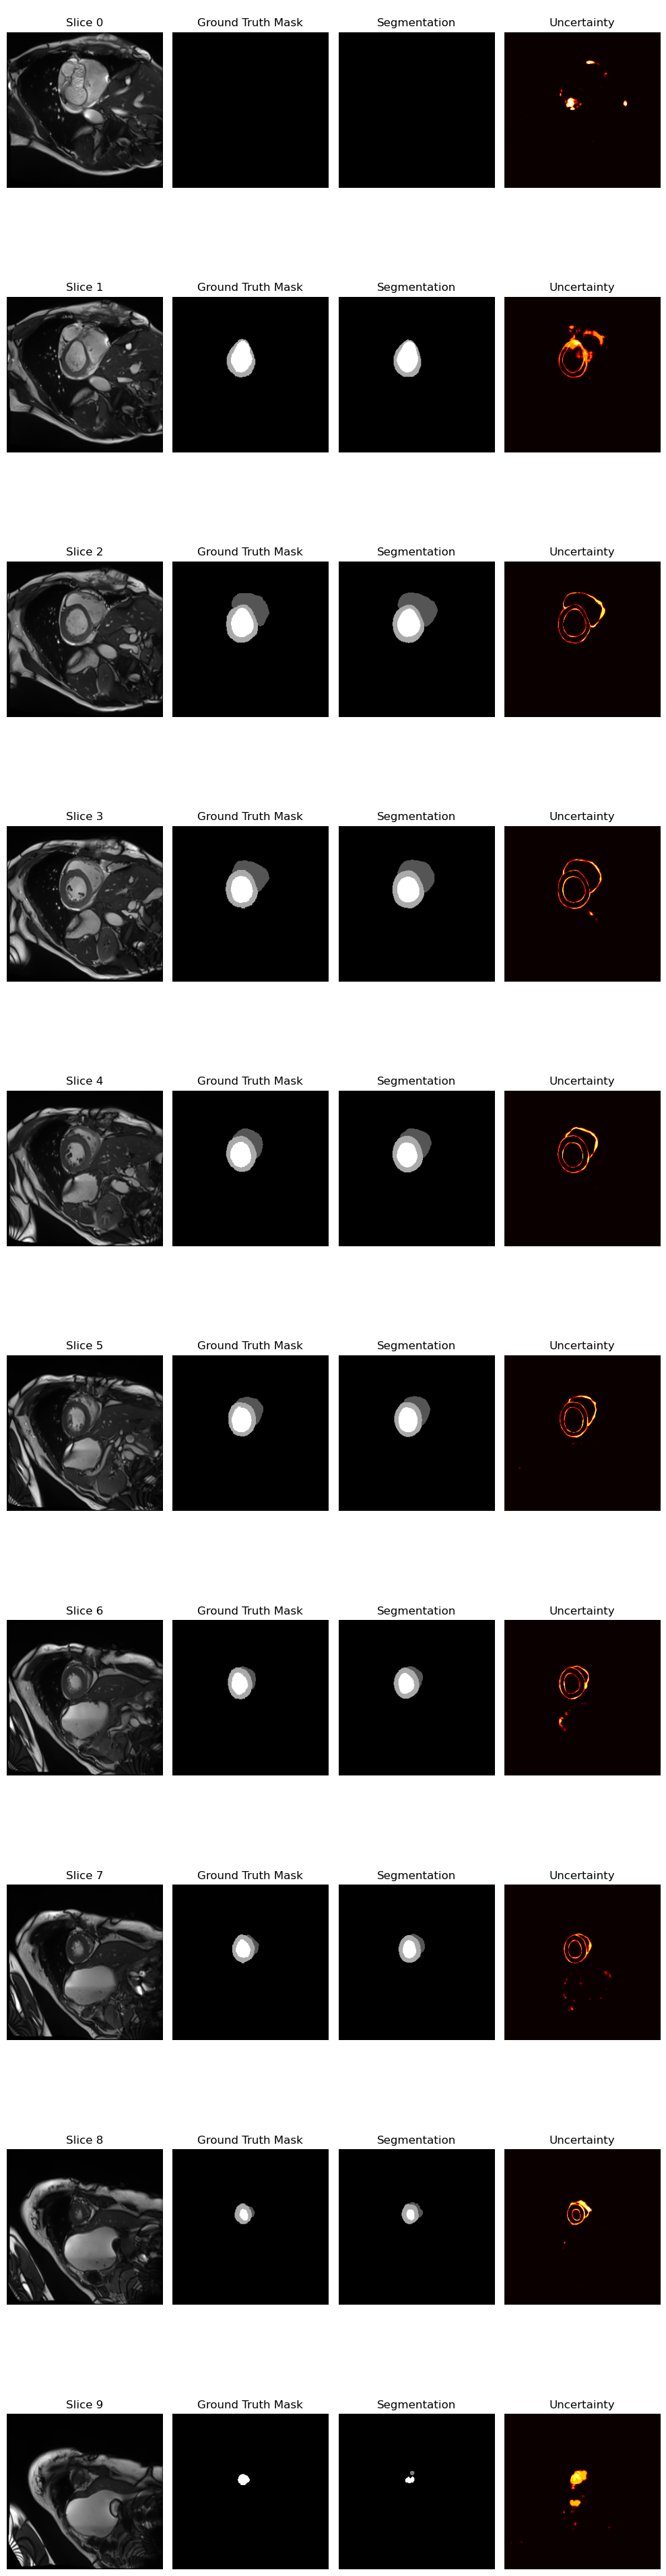

In [12]:
#VISUALISATION

#resize image because we do not want to apply the transform on the visualized image but (weird intensities) we do want it to be the same size
def resize_image(img, size=(256, 256)):
    # Als img een tensor is, converteer naar numpy array
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    img_resized = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    return img_resized

num_samples = 10

indices = list(range(num_samples))

print(f"Selected test sample indices: {indices}")

# Visualize the results
fig, axes = plt.subplots(num_samples, 4, figsize=(10, 4 * num_samples))
dice_metric = DiceMetric(include_background=True, reduction="mean")

desired_patient = "patient149"
desired_frame = "frame12"
matching_samples = [s for s in test_dicts 
                    if s["patient"] == desired_patient and desired_frame in s["img_meta_dict"]["filename"]]

if len(matching_samples) == 0:
    raise ValueError(f"Geen sample gevonden voor {desired_patient} {desired_frame}")
else:
    imgsample = matching_samples[0]
    print(f"Geselecteerd sample: {imgsample['img_meta_dict']['filename']}")
 

# Inference and Debugging with Uncertainty Mapping
with torch.no_grad():
    for i, idx in enumerate(indices):
        sample = test_dataset[idx]
        
        # load the nifti images
        nifti_img = nib.load(imgsample["img"])
        img_data1 = nifti_img.get_fdata()
        img_data = resize_image(img_data1)
        
        # get the filename
        filename = sample.get("filename", sample.get("image_path", f"Slice {idx}"))
        print(f"Visualizing Sample Index: {idx}, Filename: {filename}")

        img = sample["img"].to(device).unsqueeze(0)  # Add batch dimension
        mask = sample["mask"].to(device).unsqueeze(0)  # Keep 1-channel

        # load the model
        ensemble_models = load_ensemble_models(model_paths, device)
        ensemble_model = EnsembleModel(ensemble_models, num_samples_mc=10)

        # add model on one image
        mean_pred, uncertainty = ensemble_model(img)

        # Apply softmax to the mean prediction for class probabilities
        output_prob = torch.softmax(mean_pred, dim=1)

        # Apply argmax to get the predicted class
        pred = torch.argmax(output_prob, dim=1, keepdim=True)

        # Convert tensors to numpy for plotting
        img_np = img.squeeze().cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy(
        )
        pred_np = pred.squeeze().cpu().numpy()
        uncertainty_np = uncertainty.squeeze().cpu().numpy()  # Uncertainty map (standard deviation)
        uncertainty_np = uncertainty_np.mean(axis=0)  # make 2d map

        # Compute Dice score
        mask_onehot = one_hot(mask, num_classes=4)
        pred_onehot = one_hot(pred, num_classes=4)
        dice_metric(y_pred=pred_onehot, y=mask_onehot)
        dice_score = dice_metric.aggregate().item()
        dice_metric.reset()

        # Plot the results
        axes[i, 0].imshow(img_data[..., i], cmap="gray")
        axes[i, 0].set_title(f"\n{filename}")

        axes[i, 1].imshow(mask_np, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")

        axes[i, 2].imshow(pred_np, cmap="gray")
        axes[i, 2].set_title(f"Segmentation")

        axes[i, 3].imshow(uncertainty_np, cmap="hot")  # Plot the uncertainty map (standard deviation)
        axes[i, 3].set_title("Uncertainty")

        # Hide axes for all subplots
        for ax in axes[i]:
            ax.axis("off")

plt.tight_layout()
plt.show()